In [35]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series

data=pd.read_csv('BTC-Daily.csv')


data=data.set_index(pd.DatetimeIndex(data['Date']))['Close']
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

look_back=3

#convert an array of values into a dataset matrix


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))\

# create and fit the LSTM network
from keras.layers import Activation, Dense,Dropout
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))

model.add(LSTM(256))


model.add(Dense(1))
import keras
from keras import optimizers


model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1,shuffle=False,batch_size=50)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[look_back,trainScore,testScore])


Epoch 1/50
36/36 [==============================] - 3s 19ms/step - loss: 0.0965
Epoch 2/50
36/36 [==============================] - 1s 16ms/step - loss: 0.0137
Epoch 3/50
36/36 [==============================] - 0s 12ms/step - loss: 7.1989e-04
Epoch 4/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 5/50
36/36 [==============================] - 0s 13ms/step - loss: 5.7352e-04
Epoch 6/50
36/36 [==============================] - 0s 13ms/step - loss: 4.0308e-04
Epoch 7/50
36/36 [==============================] - 0s 12ms/step - loss: 3.8012e-04
Epoch 8/50
36/36 [==============================] - 0s 12ms/step - loss: 3.7165e-04
Epoch 9/50
36/36 [==============================] - 1s 19ms/step - loss: 3.6565e-04
Epoch 10/50
36/36 [==============================] - 1s 33ms/step - loss: 3.5926e-04
Epoch 11/50
36/36 [==============================] - 1s 25ms/step - loss: 3.5311e-04
Epoch 12/50
36/36 [==============================] - 1s 27ms/step - loss: 3.4886e-04
E

<Axes: xlabel='Date'>

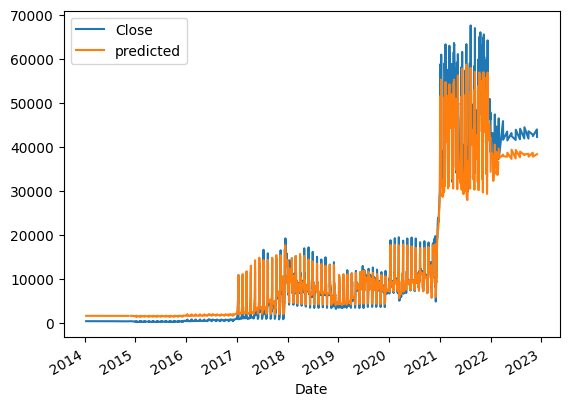

In [38]:
ans.plot()

<ipython-input-40-ad0f60020a07>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ans['2022-02'].plot()


<Axes: xlabel='Date'>

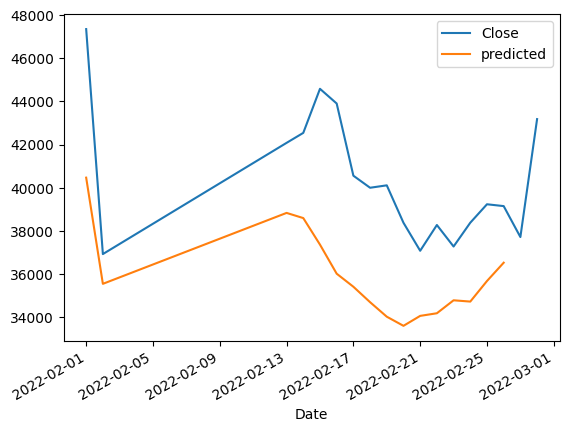

In [40]:
ans['2022-02'].plot()